Выполнить предсказание временного ряда. Разделить нужно не смешивая прошлое и будущее. 
Использовать sarima /  Prophet?
docker / собрать контейнер с tf + добавить свои данные
Electric_Production

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima

In [95]:
# загрузка временного ряда
data = pd.read_csv("Electric_Production.csv")
data["DATE"] = pd.to_datetime(data["DATE"], format="%m/%d/%Y")
data.set_index("DATE", inplace=True)

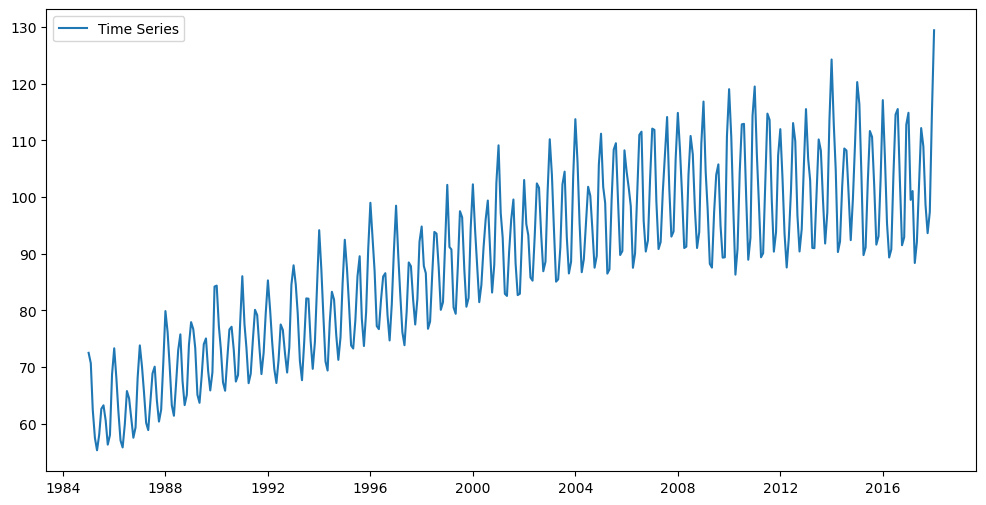

In [96]:
plt.figure(figsize=(12,6))
plt.plot(data, label="Time Series")
plt.legend()
plt.show()


In [97]:
data = data.astype(np.float32)

In [100]:
data

,IPG2211A2N
DATE,
1985-01-01,72.505203
1985-02-01,70.671997
1985-03-01,62.450199
1985-04-01,57.471401
1985-05-01,55.315102
...,...
2017-09-01,98.615402
2017-10-01,93.613701
2017-11-01,97.335899


Оценим корреляцию данных для определения сезонности

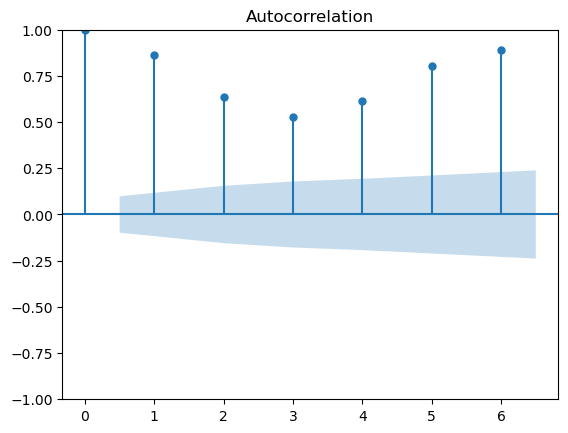

In [101]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data, lags=6) 
plt.show()


In [103]:
%%capture
# Подбор параметров

stepwise_model = auto_arima(data, seasonal=True, m=6,  # m - сезонность 
                            trace=False,  
                            suppress_warnings=True)



In [104]:
# Обучение модели
sarima_model = sm.tsa.statespace.SARIMAX(data,
                                         order=stepwise_model.order,
                                         seasonal_order=stepwise_model.seasonal_order,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False).fit()
print(sarima_model.summary())

d:\soft\Anaconda\envs\ML1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\soft\Anaconda\envs\ML1\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                             IPG2211A2N   No. Observations:                  397
Model:             SARIMAX(4, 1, 1)x(2, 0, [1, 2], 6)   Log Likelihood                -867.356
Date:                                Sat, 15 Feb 2025   AIC                           1754.711
Time:                                        15:54:46   BIC                           1794.113
Sample:                                    01-01-1985   HQIC                          1770.346
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4974      0.058      8.640      0.000       0.385       0.610
ar.

d:\soft\Anaconda\envs\ML1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\LP\AppData\Local\Temp\ipykernel_44180\3441044309.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data.index[-1], periods=future_steps+1, freq="M")[1:]


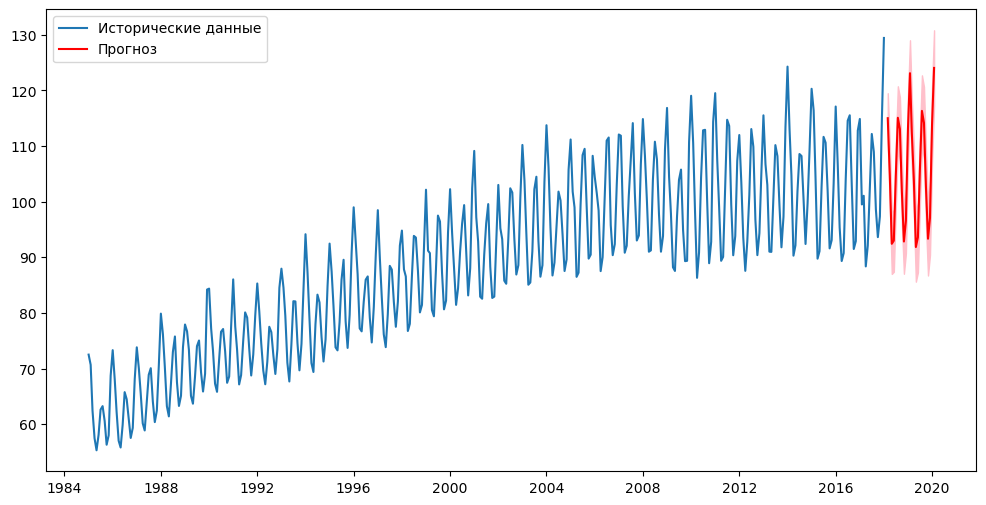

In [105]:
future_steps = 24  # Число предсказываемых шагов
forecast = sarima_model.get_forecast(steps=future_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=future_steps+1, freq="M")[1:]

# Доверительный интервал
confidence_interval = forecast.conf_int()

# График
plt.figure(figsize=(12,6))
plt.plot(data, label="Исторические данные")
plt.plot(forecast_index, forecast.predicted_mean, label="Прогноз", color="red")
plt.fill_between(forecast_index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='pink', alpha=1)
plt.legend()
plt.show()


Используем Prophet

In [76]:
from prophet import Prophet

In [77]:

data = pd.read_csv("Electric_Production.csv")

# Преобразуем колонку с датами
data["ds"] = pd.to_datetime(data["DATE"],format="%m/%d/%Y")
data["y"] = data["IPG2211A2N"]  # Приведение к нужному формату Prophet

data = data[["ds", "y"]]


print(data.head())


          ds        y
0 1985-01-01  72.5052
1 1985-02-01  70.6720
2 1985-03-01  62.4502
3 1985-04-01  57.4714
4 1985-05-01  55.3151


In [90]:
# Создаём модель Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=1)

# Обучаем модель на данных
model.fit(data)



13:55:47 - cmdstanpy - INFO - Chain [1] start processing
13:55:47 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
future = model.make_future_dataframe(periods=730)  # Прогноз на 2 года вперёд
forecast = model.predict(future)

d:\soft\Anaconda\envs\ML1\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\soft\Anaconda\envs\ML1\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


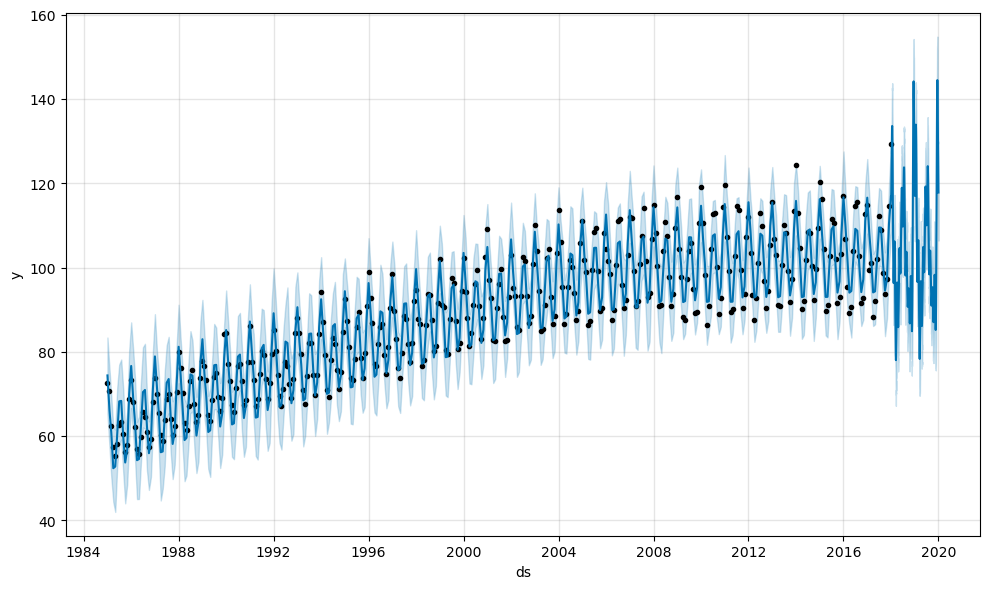

In [92]:
fig = model.plot(forecast)
plt.show()


В ходе работы выполнено предсказание временного ряда с помощью Sarima и Prophet.
Модель Sarima показала более правдоподобные результаты, нежели Prophet.